In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-n653gjb4
  Running command git clone -q https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-n653gjb4
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 15.7 MB 9.7 kB/s 
     |████████████████████████████████| 11.3 MB 66.9 MB/s 
     |████████████████████████████████| 61 kB 7.4 MB/s 
     |████████████████████████████████| 9.7 MB 73.2 MB/s 
     |████████████████████████████████| 121 kB 84.8 MB/s 
     |████████████████████████████████| 965 kB 82.2 MB/s 
     |████████████████████████████████| 1.6 MB 67.7 MB/s 
     |████████████████████████████████| 83 kB 2.6 MB/s 
  Created wheel

In [ ]:
pip install matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pathlib
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from torch import nn
from sklearn.model_selection import train_test_split

import json
import multiprocessing
import glob

In [ ]:
from d2l import torch as d2l

In [ ]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [ ]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir,
        'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # load pretrained BERT params
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

In [ ]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

正在从http://d2l-data.s3-accelerate.amazonaws.com/bert.small.torch.zip下载../data/bert.small.torch.zip...


In [ ]:
print(type(vocab.idx_to_token))
len(vocab.idx_to_token)

<class 'list'>


60005

# Data preprocessing

## put patients or healthy subject's acquisitions to EEG folders

## patient's data without 134733100.0 are 24 rows (global min)
## (17, 24, 8000)
## (16, 24, 8000)

## for healthy subjcts is 29

In [ ]:
class EEGLoader(Dataset):
  def __init__(self,root):
    super(EEGLoader,self).__init__()
    self.root = root
    self.name2label = {}
    for name in sorted(os.listdir(os.path.join(root))):
      if not os.path.isdir(os.path.join(root,name)):
        continue
      self.name2label[name] = len(self.name2label.keys())
    print(self.name2label)

    # no enough data, so split two dataset manually. Just in case use shuffle,split will get only one or two samples for test 
    # assert len(data) == len(labels)


  # def load_csv(self,filename):
  #     data  = []
  #     for name in self.name2label.keys():
  #       print("name",name)
  #       data +=glob.glob(os.path.join(self.root,name,'*.csv'))
  #       # 。split(os.sep)[-2]
  #     print(len(data),data)


  def load_csv(self,foldername):
      # data  = []
      data =glob.glob(os.path.join(self.root,foldername,'*.csv'))
      # 。split(os.sep)[-2]
      print(len(data),data)

      res = []
      for file in data:
        EEGMatrix = pd.read_csv(file,header=None).values
        EEGwithoutConstantValue = []
        for channel in EEGMatrix:
          # print("channel len",len(channel))
          # for testing since number of each acquisition's unique channels without 134733100 is different. get min number 29 rows first. Do data preprocessing to reduce channels to 17 later.
          if 134733100.0 in channel:
            continue
          EEGwithoutConstantValue.append(channel)
        # print(np.array(EEGwithoutConstantValue).shape)
        EEGwithoutConstantValue = EEGwithoutConstantValue[:24]
        # print(np.array(EEGwithoutConstantValue).shape)
        res.append(EEGwithoutConstantValue)
      return res
  

  def __len__(self):
      pass

  def __getitem__(self,idx):
      pass
data = EEGLoader('/content/drive/MyDrive/EEG')

resting_list = data.load_csv("01-health")
music_list = data.load_csv("08-health")

print(np.array(resting_list).shape)
print(np.array(music_list).shape)

# 9,24,8000
# acqusition, channel, feature


# 9,24*128,400


{'01': 0, '01-health': 1, '01-previous': 2, '08': 3, '08-health': 4, '08-previous': 5}
90 ['/content/drive/MyDrive/EEG/01-health/Acquisition 19-rawTrigger8-1.csv', '/content/drive/MyDrive/EEG/01-health/Acquisition 19-rawTrigger8-3.csv', '/content/drive/MyDrive/EEG/01-health/Acquisition 19-rawTrigger8-5.csv', '/content/drive/MyDrive/EEG/01-health/Acquisition 19-rawTrigger8-4.csv', '/content/drive/MyDrive/EEG/01-health/Acquisition 19-rawTrigger8-2.csv', '/content/drive/MyDrive/EEG/01-health/Acquisition 19-rawTrigger8-9.csv', '/content/drive/MyDrive/EEG/01-health/Acquisition 19-rawTrigger8-6.csv', '/content/drive/MyDrive/EEG/01-health/Acquisition 19-rawTrigger8-8.csv', '/content/drive/MyDrive/EEG/01-health/Acquisition 19-rawTrigger8-7.csv', '/content/drive/MyDrive/EEG/01-health/Acquisition 19-rawTrigger8-10.csv', '/content/drive/MyDrive/EEG/01-health/Acquisition 20-rawTrigger8-3.csv', '/content/drive/MyDrive/EEG/01-health/Acquisition 20-rawTrigger8-1.csv', '/content/drive/MyDrive/EEG/01-h

In [ ]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.optimizers import Adam, Nadam, RMSprop

In [ ]:
# 测试lstm

# train
x_train_a = resting_list[:60]
# .reshape((300,160,24))
x_train_a  = np.array(x_train_a)
x_train_a.shape

x_train_b = music_list[:150]
# .reshape((300,160,24))
x_train_b = np.array(x_train_b)
x_train = np.vstack((x_train_a,x_train_b))
x_train.shape

x_train /= 200
x_train = x_train.astype("float32")

# test
x_test_a = resting_list[60:]
# .reshape((150,160,24))
x_test_a  = np.array(x_test_a)
x_test_a.shape
print(len(x_test_a))

x_test_b = music_list[150:]
# .reshape((150,160,24))
x_test_b = np.array(x_test_b)
x_test = np.vstack((x_test_a,x_test_b))
x_test.shape

x_test /= 200
x_test = x_test.astype("float32")
print(len(x_test))
# labels
y_train = np.append(np.zeros(len(x_train_a),dtype=int), np.ones(len(x_train_b),dtype=int))
y_train.shape

y_train = np_utils.to_categorical(y_train,2)
y_train = y_train.astype("float32")
y_train

y_test = np.append(np.zeros(len(x_test_a),dtype=int), np.ones(len(x_test_b),dtype=int))
y_test.shape


y_test = np_utils.to_categorical(y_test,2)
y_test = y_test.astype("float32")

# example  x_train = data.reshape((316,500,28))
# 因为8000这个其实就是timestamp. 那用window拖长的话。 时间属性

30
72


In [ ]:
len(y_train)

12

In [ ]:
model = Sequential()
model.add(LSTM(10, return_sequences = True, input_shape=(24,8000)))
model.add(LSTM(10, return_sequences = True))
model.add(LSTM(5))
model.add(Dense(2, activation ='softmax'))
model.summary()

optim = Nadam(learning_rate = 0.001)

model.compile(loss = 'categorical_crossentropy', optimizer=optim, metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 10)            320440    
                                                                 
 lstm_1 (LSTM)               (None, 24, 10)            840       
                                                                 
 lstm_2 (LSTM)               (None, 5)                 320       
                                                                 
 dense (Dense)               (None, 2)                 12        
                                                                 
Total params: 321,612
Trainable params: 321,612
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train,y_train,epochs=40,batch_size=1)

Epoch 1/40
210/210 [==============================] - 10s 9ms/step - loss: 0.6298 - accuracy: 0.7143
Epoch 2/40
210/210 [==============================] - 2s 9ms/step - loss: 0.6025 - accuracy: 0.7095
Epoch 3/40
210/210 [==============================] - 2s 9ms/step - loss: 0.5982 - accuracy: 0.7143
Epoch 4/40
210/210 [==============================] - 2s 8ms/step - loss: 0.5888 - accuracy: 0.7143
Epoch 5/40
210/210 [==============================] - 2s 9ms/step - loss: 0.5829 - accuracy: 0.7143
Epoch 6/40
210/210 [==============================] - 2s 8ms/step - loss: 0.5769 - accuracy: 0.7143
Epoch 7/40
210/210 [==============================] - 2s 9ms/step - loss: 0.5809 - accuracy: 0.7143
Epoch 8/40
210/210 [==============================] - 2s 9ms/step - loss: 0.5696 - accuracy: 0.7143
Epoch 9/40
210/210 [==============================] - 2s 9ms/step - loss: 0.5624 - accuracy: 0.7143
Epoch 10/40
210/210 [==============================] - 2s 9ms/step - loss: 0.5662 - accuracy: 0.714

In [ ]:
len(y_test)

300

In [ ]:
score,acc = model.evaluate(x_test,y_test,batch_size=1)
print("score",score)
print("acc", acc)
len(x_test)

300/300 [==============================] - 3s 7ms/step - loss: 0.8877 - accuracy: 0.2567
score 0.887744665145874
acc 0.2566666603088379


300

In [ ]:
from tensorflow import keras
from keras.layers import *
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
import datetime
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import optimizers
from keras.layers import Reshape

In [ ]:
# cnn
# (192, 24, 8000) -> transpose 192 8000 24 -> reshape 192,20,400,24 
# 192,8000,2
# 变成(192,20,400,24)
inputs = Input(shape=(20,400,24))
# inputs = Input(shape=(24, 8000, 1))
conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(32, 3, activation='relu', padding='same')(pool1)
conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv3)
conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv3)
conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv3)

# input_shape = [10, 200, 32], output_shape = [8000, 2]  其实并不是一定跟最早的8000一致。 需要一致的是维度吧？ 只需要把前两个维度合并， 变成[2000,32]就可以了。 并不是一定得前面做一次conv2d，让filterdeng等于2？
reshape = Reshape((2000,32))(conv3)

D1 = Dropout(0.1)(reshape)
D1 = Flatten()(D1)
D1 = Dense(32,activation='relu')(D1) #relu
Out = Dense(2, activation='softmax')(D1)

model = Model(inputs, Out)
model.summary()

opt = optimizers.Adam(learning_rate=0.0001, decay=1e-6) #0.002， 0.0005
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 20, 400, 24)]     0         
                                                                 
 conv2d_42 (Conv2D)          (None, 20, 400, 32)       6944      
                                                                 
 conv2d_43 (Conv2D)          (None, 20, 400, 32)       9248      
                                                                 
 conv2d_44 (Conv2D)          (None, 20, 400, 32)       9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 200, 32)      0         
 2D)                                                             
                                                                 
 conv2d_45 (Conv2D)          (None, 10, 200, 32)       9248      
                                                           

In [ ]:
x_test = x_test.transpose(0,2,1).reshape((72,20,400,24))

In [ ]:
x_train= x_train.transpose(0,2,1)
x_train.shape
x_train = x_train.reshape((210,20,400,24 ))
x_train.shape

x_test = x_test.transpose(0,2,1).reshape((72,20,400,24))


ValueError: ignored

In [ ]:
history = model.fit(x_train,y_train,epochs=15,batch_size=3)

Epoch 1/15
70/70 [==============================] - 1s 6ms/step - loss: 1.4613 - accuracy: 0.6333
Epoch 2/15
70/70 [==============================] - 0s 5ms/step - loss: 0.6433 - accuracy: 0.7143
Epoch 3/15
70/70 [==============================] - 0s 5ms/step - loss: 0.6244 - accuracy: 0.7143
Epoch 4/15
70/70 [==============================] - 0s 5ms/step - loss: 0.6233 - accuracy: 0.7143
Epoch 5/15
70/70 [==============================] - 0s 5ms/step - loss: 0.6221 - accuracy: 0.7143
Epoch 6/15
70/70 [==============================] - 0s 6ms/step - loss: 0.6352 - accuracy: 0.7143
Epoch 7/15
70/70 [==============================] - 0s 6ms/step - loss: 0.6199 - accuracy: 0.7143
Epoch 8/15
70/70 [==============================] - 0s 6ms/step - loss: 0.6188 - accuracy: 0.7143
Epoch 9/15
70/70 [==============================] - 0s 5ms/step - loss: 0.6177 - accuracy: 0.7143
Epoch 10/15
70/70 [==============================] - 0s 5ms/step - loss: 0.6166 - accuracy: 0.7143
Epoch 11/15
70/70 [

In [ ]:
test_loss,test_acc = model.evaluate(x_test,y_test)

3/3 [==============================] - 2s 254ms/step - loss: 0.6853 - accuracy: 0.5833


In [ ]:
music_list = np.reshape(np.array(music_list),(-1,8000))
music_list.shape

(216, 8000)

In [ ]:
 np.savetxt("testFFT.csv",music_list,delimiter=",")

In [ ]:
np.min(music_list)
a =  ['FP1','FP2','F7','F3','FZ','F4','F8','FT7','FC3','FCZ','FC4','FT8','T7','C3','CZ','C4','T8','TP7','CP3','CPZ','CP4','TP8','A1','P7','P3','PZ','P4','P8','A2','O1','OZ','O2']
len(a)

32

In [ ]:
def window(data,kernel_size, stride=10):
  res = []
  previous = 0
  for i in range(stride, len(data),stride):
    # print("start", previous,"end",previous + kernel_size)
    # print(data[previous:previous + kernel_size])
    # print(type(data[previous:previous + kernel_size]))
    res.append(data[previous:previous + kernel_size])
    if previous + kernel_size == len(data):
      break
    previous = i
  # for i in res:
  #   if len(i)!= 100:
  #     print(len(i))
  return res
# 每一个1x8000，变成了159x100
# 所以每一个acquisition有24行， 那17个或者16个acquisition，就会有408跟384
rsWindowList = []
musicWindowList = []

for acqusition in resting_list:
  for channel in acqusition:
    # print(np.array(window(channel,100,50)).shape)
    rsWindowList.append(window(channel,100,50))
print(np.array(rsWindowList).shape)

for acqusition in music_list:
  for channel in acqusition:
    musicWindowList.append(window(channel,100,50))
print(np.array(musicWindowList).shape)


rsWindowList = np.reshape(np.array(rsWindowList),(-1,100))
musicWindowList = np.reshape(np.array(musicWindowList),(-1,100))

print(np.array(rsWindowList).shape)
print(np.array(musicWindowList).shape)

(216, 159, 100)
(216, 159, 100)
(34344, 100)
(34344, 100)


In [ ]:
totalList = np.vstack((rsWindowList,musicWindowList))
totalList = totalList.astype(np.int64)
totalList.shape


(68688, 100)

In [ ]:
# healthy subject:
# min -54388
# max 132496

# patient
# min -34910
# max 124135
print(np.min(totalList)) 
print(np.max(totalList)) 

-54388
132496


In [ ]:
 np.savetxt("beforeQuantiz.csv",totalList,delimiter=",")

In [ ]:
# test
tmp = range (-38604,17153,2)
partition = list(tmp)
partition.append(17153)
print(len(partition))

print(len(range(200,28081)))

# EEG
tmp = range (-54388,132496,7)
partition = list(tmp)
partition.append(132496)
print(len(partition))

print(len(range(200,26899)))

27880
27881
26699
26699


In [ ]:

a = np.arange(60).reshape(3,10,2)+10
print(a)
a = a.reshape((6,5,2))
print("second one")
print(a)

[[[10 11]
  [12 13]
  [14 15]
  [16 17]
  [18 19]
  [20 21]
  [22 23]
  [24 25]
  [26 27]
  [28 29]]

 [[30 31]
  [32 33]
  [34 35]
  [36 37]
  [38 39]
  [40 41]
  [42 43]
  [44 45]
  [46 47]
  [48 49]]

 [[50 51]
  [52 53]
  [54 55]
  [56 57]
  [58 59]
  [60 61]
  [62 63]
  [64 65]
  [66 67]
  [68 69]]]
second one
[[[10 11]
  [12 13]
  [14 15]
  [16 17]
  [18 19]]

 [[20 21]
  [22 23]
  [24 25]
  [26 27]
  [28 29]]

 [[30 31]
  [32 33]
  [34 35]
  [36 37]
  [38 39]]

 [[40 41]
  [42 43]
  [44 45]
  [46 47]
  [48 49]]

 [[50 51]
  [52 53]
  [54 55]
  [56 57]
  [58 59]]

 [[60 61]
  [62 63]
  [64 65]
  [66 67]
  [68 69]]]


In [ ]:
totalList = np.loadtxt("afterQuantizHealthy.csv",delimiter=",",dtype=int)

In [ ]:
np.min(totalList)

200

In [ ]:
print(totalList.shape)
# restList len
totalList = totalList.astype(np.int64)
restList = totalList[:34344]
musicList = totalList[34344:]

rsLabels = np.zeros(len(restList), dtype=int)
musicLabels = np.ones(len(musicList), dtype=int)

(68688, 100)


In [ ]:
# totalData = hvData+patientData
totalData = restList.tolist()+musicList.tolist()
totalLabels =  rsLabels.tolist() + musicLabels.tolist()
# totalLabels =  onehot_hvLabels.tolist() + onehot_patientLabels.tolist()
torch.tensor(totalLabels)  ### 
len(totalLabels)

68688

In [ ]:
print(7*24)
print(14*24)

print(168*159) #rest
print(336*159) #music
print(17*24*159)

168
336
26712
53424
64872


In [ ]:
a = np.ones(5)
b = np.zeros(6)
c = np.hstack((a,b))
len(c)

11

In [ ]:
x_train = restList.tolist()[:26712] + musicList.tolist()[:26712]
x_test =  restList.tolist()[26712:] + musicList.tolist()[26712:]
y_train = np.hstack((rsLabels[:26712],musicLabels[:26712]))
y_test  = np.hstack((rsLabels[26712:],musicLabels[26712:]))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(totalData, totalLabels, test_size=0.1, random_state=0)

In [ ]:
# just in case data.Dataset's format is incorrect, create a function in demo's format
def getDataset(x_train, x_test, y_train, y_test, is_train):
  if is_train:
    return x_train,y_train
  else:
    return x_test,y_test

In [ ]:
class EGGBERTDataset(torch.utils.data.Dataset):
  # dataset[0]:data, dataset[1]:label 
    def __init__(self, dataset, max_len, vocab=None):
        self.labels = torch.tensor(dataset[1])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(dataset[0])
        print("dataset len ",len(dataset[0]))
        print('read ' + str(len(self.all_token_ids)) + ' examples')


    def _preprocess(self, all_tokens):
      pool = multiprocessing.Pool(4)  
      out = pool.map(self._get_tokens_and_segments, all_tokens)
      print("all tokens ",len(all_tokens))
      print("first token ", all_tokens[0])
      print("out len ",len(out))
      all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
      all_segments = [segments for token_ids, segments, valid_len in out]
      valid_lens = [valid_len for token_ids, segments, valid_len in out]

      print("len of token " ,len(all_token_ids[0]))
      print("len of segment " ,len(all_segments[0]))
      return (torch.tensor(all_token_ids, dtype=torch.long),
              torch.tensor(all_segments, dtype=torch.long),
              torch.tensor(valid_lens))

    def _get_tokens_and_segments(self,tokens_a, tokens_b=None):
        """获取输入序列的词元及其片段索引

        Defined in :numref:`sec_bert`"""
        # <cls> = 3, <sep> = 4
        tokens = [3] + tokens_a + [4]
        # 0和1分别标记片段A和B
        segments = [0] * (len(tokens_a) + 2)
        if tokens_b is not None:
            tokens += tokens_b + ['4']
            segments += [1] * (len(tokens_b) + 1)
        
        # 1 = ,[<pad>]
        pad_tokens = tokens + [1] \
                                * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))


        # print(tokens)
        valid_len = len(tokens)
   
        torch.tensor(pad_tokens,dtype=torch.long)
        torch.tensor(segments,dtype=torch.long)
        torch.tensor(valid_len)
        return pad_tokens,segments,valid_len


    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)
# test_set = EGGBERTDataset( getDataset(x_train, x_test, y_train, y_test, False), 128, vocab)

In [ ]:
batch_size, max_len, num_workers = 64, 128,2
train_set = EGGBERTDataset( getDataset(x_train, x_test, y_train, y_test, True), max_len, vocab)
test_set = EGGBERTDataset( getDataset(x_train, x_test, y_train, y_test, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

all tokens  53424
first token  [4159, 4160, 4163, 4166, 4167, 4169, 4169, 4168, 4169, 4168, 4166, 4162, 4162, 4159, 4157, 4158, 4157, 4156, 4159, 4164, 4165, 4166, 4169, 4169, 4169, 4170, 4168, 4164, 4161, 4160, 4158, 4158, 4159, 4157, 4158, 4161, 4164, 4164, 4167, 4169, 4167, 4168, 4168, 4166, 4162, 4161, 4160, 4158, 4159, 4158, 4155, 4156, 4159, 4162, 4163, 4166, 4167, 4167, 4168, 4167, 4164, 4161, 4161, 4160, 4158, 4159, 4158, 4157, 4160, 4164, 4164, 4166, 4167, 4166, 4166, 4167, 4166, 4163, 4160, 4160, 4158, 4157, 4158, 4156, 4158, 4160, 4163, 4164, 4166, 4168, 4167, 4168, 4167, 4166, 4162, 4160, 4159, 4157, 4159, 4158]
out len  53424
len of token  128
len of segment  128
dataset len  53424
read 53424 examples
all tokens  15264
first token  [3674, 3672, 3671, 3672, 3672, 3672, 3673, 3673, 3672, 3673, 3673, 3672, 3673, 3673, 3672, 3670, 3670, 3670, 3668, 3668, 3669, 3668, 3667, 3664, 3665, 3664, 3660, 3658, 3662, 3667, 3670, 3673, 3674, 3675, 3675, 3674, 3673, 3671, 3669, 3668, 3667

# Fine tuning

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256,2)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :])) # get embedding feature of first token

In [ ]:
net = BERTClassifier(bert) # <- load_pretrained_model

# healthy subject performance

loss 0.018, train acc 0.993, test acc 0.984
1882.7 examples/sec on [device(type='cuda', index=0)]


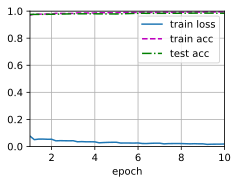

In [ ]:
lr, num_epochs = 1e-4, 10 
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
# loss = nn.BCELoss()
# Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 2])) is deprecated. Please ensure they have the same size.
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

# patient performance

loss 0.029, train acc 0.989, test acc 0.982
1863.0 examples/sec on [device(type='cuda', index=0)]


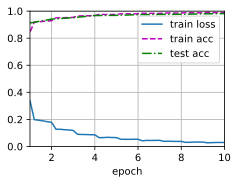

In [ ]:
lr, num_epochs = 1e-4, 10 
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
# loss = nn.BCELoss()
# Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 2])) is deprecated. Please ensure they have the same size.
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

loss 0.012, train acc 0.995, test acc 0.985
1861.7 examples/sec on [device(type='cuda', index=0)]


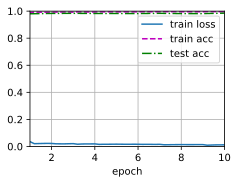

In [ ]:
lr, num_epochs = 1e-4, 10 
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
# loss = nn.BCELoss()
# Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 2])) is deprecated. Please ensure they have the same size.
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

# after manually split train and test

loss 0.017, train acc 0.993, test acc 0.399
1871.0 examples/sec on [device(type='cuda', index=0)]


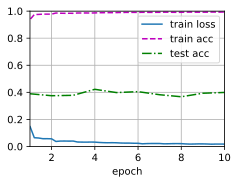

In [ ]:
lr, num_epochs = 1e-4, 10 
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
# loss = nn.BCELoss()
# Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 2])) is deprecated. Please ensure they have the same size.
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

In [ ]:
m = nn.Linear(20, 30)
input = torch.randn(128, 20)
print(input.dtype)
output = m(input) 
print(output.size())
print(output.dtype)

print(np.array(resting_list).shape)


resting_list = np.array(resting_list)

a = torch.tensor(resting_list.reshape(9,-1))
print(a.shape)
print(a.dtype)
print(input.shape)
l = nn.Linear(192000,80,dtype=torch.float64)
output = l(a)

print(output.size())



aa = np.arange(12).reshape(3,4)
print(aa.shape)
aa.reshape(4,3)
print(aa.shape)


aa = torch.tensor(aa)
aa.shape
aa.reshape(4,3)
print(aa.shape)
b= aa.view(4,3)
print("first one",b)
c = aa.reshape(4,3)
print("test c",c)
aa.fill_(1)
print(b)
print(c)


z = torch.zeros(3, 2)
y = z.reshape(6)
x = z.t().reshape(6)
z.fill_(1)

print(y)

print(x)


torch.float32
torch.Size([128, 30])
torch.float32
(9, 24, 8000)
torch.Size([9, 192000])
torch.float64
torch.Size([128, 20])
torch.Size([9, 80])
(3, 4)
(3, 4)
torch.Size([3, 4])
first one tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])
test c tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])
tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])
tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])
tensor([1., 1., 1., 1., 1., 1.])
tensor([0., 0., 0., 0., 0., 0.])
